In [1]:
import torch
import math
from torch import Tensor
import matplotlib.pyplot as plt 

In [2]:
def generate_disc_set(nb):
    input_ = Tensor(nb, 2).uniform_(0,1)
    disk_center = Tensor(nb, 2).fill_(0.5)
    #ones_ = torch.ones(nb,2)
    R = 1/math.sqrt(2*math.pi) # Radius of the disk
    target = (R - (disk_center - input_).pow(2).sum(1).sqrt()).sign()#.long()
    target.add_(1).div_(2) # to transform [-1,1] into [0,1]
    return input_, target

train_input, train_target = generate_disc_set(1000)
test_input, test_target = generate_disc_set(1000)

mini_batch_size = 100
print (train_input.size(), train_target.size())
print(train_target.size())

torch.Size([1000, 2]) torch.Size([1000])
torch.Size([1000])


#samples:        torch.Size([1000, 2])
#true_samples:   torch.Size([483, 2])
#false_samples:  torch.Size([517, 2])
torch.Size([1000, 2])


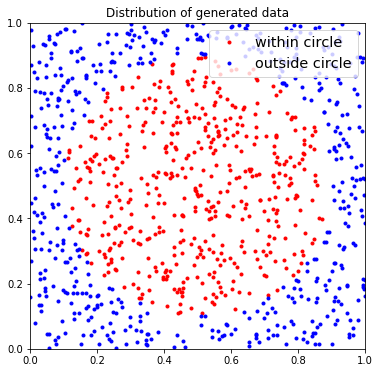

In [3]:
def plot_data(input_, target_, figure_size = 6):
    input_true = torch.Tensor(0,2)
    input_false = torch.Tensor(0,2)
    for i,x in enumerate(input_):
        if target_[i] == 0 :
            input_false = torch.cat((input_false, input_[i,:].view(-1,2)),0 )
        else :
            input_true = torch.cat( (input_true, input_[i,:].view(-1,2)),0 )
    print ('#samples:       ',input_.size())
    print ('#true_samples:  ',input_true.size())
    print ('#false_samples: ',input_false.size())
    p1 = plt.figure(1,figsize=(figure_size,figure_size))
    plt.plot(input_true[:,0].numpy(),input_true[:,1].numpy(),'r.',label='within circle')
    plt.plot(input_false[:,0].numpy(),input_false[:,1].numpy(),'b.',label='outside circle')
    plt.xlim(0,1), plt.ylim(0,1)
    plt.legend(fontsize='x-large')
    plt.title('Distribution of generated data')
    
    
plot_data(train_input, train_target)
train_target = torch.cat((1-train_target.unsqueeze(1), train_target.unsqueeze(1)),1)
print(train_target.size())

In [4]:
mu, std = train_input.mean(),train_input.std()
train_input.sub_(mu).div_(std)
mu, std = test_input.mean(),test_input.std()
test_input.sub_(mu).div_(std)        


 1.1494 -1.0864
 1.1466 -0.3749
-0.9017 -1.0002
       ⋮        
 1.3303 -0.4098
-0.8269 -1.7028
 0.2946  1.2616
[torch.FloatTensor of size 1000x2]

In [5]:
class Module ( object ) :
    def forward ( self , * input ) :
        raise NotImplementedError
        
    def backward ( self , * gradwrtoutput ) :
        raise NotImplementedError
        
    def param ( self ) :
        return [] 
    
    def zero_grad ( self ) :
        pass
    
    def reset_params( self ) :
        pass
    

class Optimizer(object):
    def step(self, Sequential, lr, *input):
        raise NotImplementedError

            

In [6]:
class SGDOptimizer(Optimizer):
    def __init__(self, Sequential, lr):
        super().__init__()
        
        self.Sequential = Sequential
        self.lr = lr
        
    def step(self):
        for param in self.Sequential.params:
            param[0][0].add_(- self.lr * param[1][0])
            param[0][1].add_(- self.lr * param[1][1])
        
        self.Sequential.zero_grad()

class SGDmomOptimizer(Optimizer):
    
    def __init__(self, Sequential, lr, gamma):
        super().__init__()
        self.Sequential = Sequential
        self.lr = lr
        self.gamma = gamma
        self._initialize_u()
        
    def step(self):
        for i,param in enumerate(self.Sequential.params):
            for j in range(2):
                param[0][j].sub_(self.lr * (self.gamma * self.u[2*i+j] +  param[1][j]))
                self.u[2*i+j] = param[0][j]
            
    def _initialize_u(self):
        self.u = []
        for param in self.Sequential.params:
            self.u.append(torch.zeros_like(param[0][0]))
            self.u.append(torch.zeros_like(param[0][1]))

class AdamOptimizer(Optimizer):
    def __init__(self, Sequential, lr, b1=0.9, b2=0.999):
        super().__init__()
        
        self.Sequential = Sequential
        self.lr = lr
        self.b1 = b1
        self.b2 = b2
        self._initialize_m()
        self._initialize_v()
        
    def step(self):
        for i,param in enumerate(self.Sequential.params):
            for j in range(2):
                self.m[2*i+j] = self.b1*self.m[2*i+j] + (1-self.b1)*param[1][j]
                self.v[2*i+j] = self.b2*self.v[2*i+j] + (1-self.b2)*param[1][j]**2
                
                mhat = (1/(1-self.b1))*self.m[2*i+j]
                vhat = (1/(1-self.b2))*self.v[2*i+j]
                
                div = torch.sqrt(vhat)+torch.Tensor(vhat.size()).normal_(mean = 0, std = 1e-6)
                
                param[0][j].sub_(self.lr * mhat/div)

            
    def _initialize_m(self):
        self.m = []
        for param in self.Sequential.params:
            self.m.append(torch.zeros_like(param[0][0]))
            self.m.append(torch.zeros_like(param[0][1]))
            
    def _initialize_v(self):
        self.v = []
        for param in self.Sequential.params:
            self.v.append(torch.zeros_like(param[0][0]))
            self.v.append(torch.zeros_like(param[0][1]))

In [7]:
class Linear(Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        
        self.weights = torch.Tensor(out_features, in_features).normal_(mean=0, std = 1)
        self.bias = torch.Tensor(out_features).uniform_(0,0)
        
        self.dl_dw = torch.Tensor(out_features, in_features)
        self.dl_db = torch.Tensor(out_features)
        self.zero_grad()
        
        self.params = [(self.weights, self.bias),(self.dl_dw, self.dl_db)]
        
    def forward(self,x):
        self.x = x
        if(x.size()[1]!=self.in_features):
            raise TypeError('Size of x should correspond to size of linear module')
        return torch.mm(x,self.weights.t()) + self.bias.expand(x.size()[0], self.out_features)
    
    def backward(self, d_dx):
        self.dl_db = torch.mean(d_dx,0)
        self.dl_dw = torch.mm(d_dx.t(), self.x)
        return torch.mm(d_dx,self.weights)
        
    def param(self):
        self.params = [(self.weights, self.bias),(self.dl_dw, self.dl_db)]
        return self.params
    
    def zero_grad(self):
        self.dl_db.zero_()
        self.dl_dw.zero_()
        
    def reset_params(self):
        self.weights.normal_(mean=0, std = 1)
        self.bias.uniform_(0,0)
        self.zero_grad()
        self.params = [(self.weights, self.bias),(self.dl_dw, self.dl_db)]
               
        
class Sequential(Module):
    def __init__(self, modules, loss):
        super().__init__()
        
        self.modules = modules
        self.loss = loss
        self.params = []
        self.param()
        
    def add(self, new_modules):
        self.modules.append(new_modules)

    def forward(self, x):
        for module in self.modules:
            x = module.forward(x)
        return x

    def backward(self):
        d_dx = self.loss.backward()  
        for module in reversed(self.modules):
            d_dx = module.backward(d_dx)
        self.param()

    def zero_grad(self):
        for module in self.modules:
            module.zero_grad()

    def param(self):
        self.params = []
        for module in self.modules:
            if(module.params):
                self.params.append(module.param())
                
    def reset_params(self):
        for module in self.modules:
            module.reset_params()
                
            
class LeakyReLU(Module):
    def __init__(self, alpha):
        super().__init__()
        
        self.params = []
        self.alpha = alpha
        
    def forward(self, x):
        self.x = x
        return x*((x>0).type(torch.FloatTensor)+self.alpha*(x<0).type(torch.FloatTensor))
    
    def backward(self, d_dx):
        return d_dx*((self.x>0).type(torch.FloatTensor)+self.alpha*(self.x<0).type(torch.FloatTensor))
        
    def param(self):
        return self.params
    
class ReLU(Module):
    def __init__(self):
        super().__init__()
        
        self.params = []
        
    def forward(self, x):
        self.x = x
        return x*(x>0).type(torch.FloatTensor)
    
    def backward(self, d_dx):
        return d_dx*(self.x>0).type(torch.FloatTensor)
        
    def param(self):
        return self.params
    
    
class Tanh(Module):
    def __init__(self):
        super().__init__()
        
        self.params = []
        
    def forward(self, x):
        self.x = x
        return 0.5*(1+x.tanh())
    
    def backward(self, d_dx):
        return 0.5*d_dx*(1-torch.tanh(self.x)**2)
    
    def param(self):
        return self.params
    
class Sigmoid(Module):
    def __init__(self):
        super().__init__()
        
        self.params = []
        
    def forward(self, x):
        self.x = x
        return torch.sigmoid(x)
    
    def backward(self, d_dx):
        return d_dx * (torch.sigmoid(self.x*(1-torch.sigmoid(self.x))))
    
    def param(self):
        return self.params
    
    
class LossMSE(Module):
    def __init__(self):
        super().__init__()
        
        self.params = []
        
    def forward(self, y, t):
        self.y = y
        self.t = t
        return torch.dist(y,t,p=2)
    
    def backward(self):
        return 2*(self.y-self.t)
    
    def param(self):
        return self.params
    


In [8]:
Lin1 = Linear(2,20)
Lin2 = Linear(20,20)
Lin3 = Linear(20,2)
act1 = LeakyReLU(0.1)
act2 = LeakyReLU(0.1)
act3 = Sigmoid()
layers = [
    Lin1,
    act1,
    Lin2,
    act2,
    Lin3,
    act3]
loss = LossMSE()
model = Sequential(layers, loss)
#optim = SGDOptimizer(model, 0.005)
optim = SGDmomOptimizer(model, 0.0005, 0.2)
#optim = AdamOptimizer(model, 0.005)


In [9]:
loss_list = []
train_acc = []

for epoch in range(400):
    
    print("\n Epoch", epoch)
    
    batch_size = 50
    train_loss = 0
    train_accuracy = 0
    
    model.zero_grad()
    
    for b in range(0, train_input.size()[0], batch_size):
        output = model.forward(train_input[b:b+batch_size,:])
        batch_loss = loss.forward(output, train_target[b:b+batch_size,:])
        train_loss += batch_loss
        model.backward()
        optim.step()
        
        _, pred = torch.max(output,1)
        _, target = torch.max(train_target[b:b+batch_size],1)
        
        train_accuracy += torch.sum(pred==target)
        
    print("\nTraining accuracy : ", train_accuracy/train_target.size()[0])      
    print("\nTraining loss : ", train_loss)
    loss_list.append(train_loss)
    train_acc.append(train_accuracy)




 Epoch 0

Training accuracy :  0.532

Training loss :  131.1823878288269

 Epoch 1

Training accuracy :  0.54

Training loss :  129.71935749053955

 Epoch 2

Training accuracy :  0.536

Training loss :  129.24590969085693

 Epoch 3

Training accuracy :  0.535

Training loss :  128.6265368461609

 Epoch 4

Training accuracy :  0.536

Training loss :  127.71462869644165

 Epoch 5

Training accuracy :  0.526

Training loss :  126.64767932891846

 Epoch 6

Training accuracy :  0.53

Training loss :  125.80502319335938

 Epoch 7

Training accuracy :  0.505

Training loss :  124.99357414245605

 Epoch 8

Training accuracy :  0.519

Training loss :  123.95222663879395

 Epoch 9

Training accuracy :  0.534

Training loss :  122.59071445465088

 Epoch 10

Training accuracy :  0.534

Training loss :  121.31862688064575

 Epoch 11

Training accuracy :  0.535

Training loss :  120.57196950912476

 Epoch 12

Training accuracy :  0.542

Training loss :  119.97764205932617

 Epoch 13

Training accur


Training accuracy :  0.956

Training loss :  41.85770535469055

 Epoch 112

Training accuracy :  0.957

Training loss :  41.64848601818085

 Epoch 113

Training accuracy :  0.956

Training loss :  41.48436141014099

 Epoch 114

Training accuracy :  0.956

Training loss :  41.3300883769989

 Epoch 115

Training accuracy :  0.957

Training loss :  41.213505268096924

 Epoch 116

Training accuracy :  0.958

Training loss :  41.05925118923187

 Epoch 117

Training accuracy :  0.958

Training loss :  40.929428935050964

 Epoch 118

Training accuracy :  0.958

Training loss :  40.785430908203125

 Epoch 119

Training accuracy :  0.958

Training loss :  40.65838074684143

 Epoch 120

Training accuracy :  0.958

Training loss :  40.529292583465576

 Epoch 121

Training accuracy :  0.96

Training loss :  40.4082555770874

 Epoch 122

Training accuracy :  0.961

Training loss :  40.28908407688141

 Epoch 123

Training accuracy :  0.96

Training loss :  40.18215751647949

 Epoch 124

Training ac


Training accuracy :  0.981

Training loss :  33.11854410171509

 Epoch 224

Training accuracy :  0.98

Training loss :  33.09596657752991

 Epoch 225

Training accuracy :  0.98

Training loss :  33.06912314891815

 Epoch 226

Training accuracy :  0.98

Training loss :  33.039997816085815

 Epoch 227

Training accuracy :  0.982

Training loss :  32.99070060253143

 Epoch 228

Training accuracy :  0.982

Training loss :  32.96353566646576

 Epoch 229

Training accuracy :  0.982

Training loss :  32.93545937538147

 Epoch 230

Training accuracy :  0.982

Training loss :  32.905434012413025

 Epoch 231

Training accuracy :  0.981

Training loss :  32.883816838264465

 Epoch 232

Training accuracy :  0.981

Training loss :  32.865816593170166

 Epoch 233

Training accuracy :  0.981

Training loss :  32.8448680639267

 Epoch 234

Training accuracy :  0.981

Training loss :  32.81605684757233

 Epoch 235

Training accuracy :  0.98

Training loss :  32.78655242919922

 Epoch 236

Training acc


Training accuracy :  0.982

Training loss :  31.4498553276062

 Epoch 333

Training accuracy :  0.982

Training loss :  31.45312476158142

 Epoch 334

Training accuracy :  0.982

Training loss :  31.440725684165955

 Epoch 335

Training accuracy :  0.982

Training loss :  31.442991495132446

 Epoch 336

Training accuracy :  0.982

Training loss :  31.436764001846313

 Epoch 337

Training accuracy :  0.982

Training loss :  31.43260407447815

 Epoch 338

Training accuracy :  0.982

Training loss :  31.42642629146576

 Epoch 339

Training accuracy :  0.982

Training loss :  31.426978707313538

 Epoch 340

Training accuracy :  0.982

Training loss :  31.4248389005661

 Epoch 341

Training accuracy :  0.982

Training loss :  31.417033553123474

 Epoch 342

Training accuracy :  0.982

Training loss :  31.410320162773132

 Epoch 343

Training accuracy :  0.982

Training loss :  31.419785976409912

 Epoch 344

Training accuracy :  0.982

Training loss :  31.40946674346924

 Epoch 345

Traini

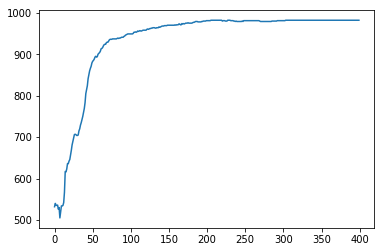

In [10]:
plt.plot(train_acc)

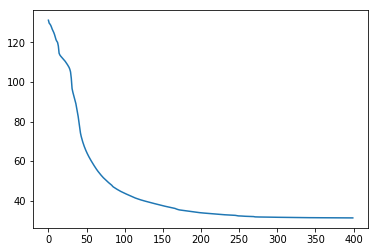

In [11]:
plt.plot(loss_list)

In [12]:
test_output = model.forward(test_input)
_, test_pred = torch.max(test_output,1)

test_accuracy = torch.sum(test_pred == test_target.type(torch.LongTensor))
print("Accuracy of model on test set : {}%".format(test_accuracy/10))

Accuracy of model on test set : 97.4%
